In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
import zipfile
import pandas as pd
import string
import math
import re
import seaborn as sns

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# filename = "sentiment_train.zip"
# with zipfile.ZipFile(filename, 'r') as zip_ref:
#     zip_ref.extractall()


**Pre Processing**

In [ ]:
#### take pos tagged file name as input and 
# give tokeinsed data and pos tagged as sepetare list
def pos_tagged_tokenised(filename):
    f = open(filename, 'r')
    text = f.read().split('\n')

    tokenised_data = []
    pos_tagged_data = []

    count = 0
    label = []
    for data in text:
        spl = data.split('\t')
        if ( len(spl) == 4):
            tokenised, pos_tags, scores, orignal = spl 
            tokenised_data.append(tokenised)
            pos_tagged_data.append(pos_tags)
            label.append(y_train[count])

        count += 1
    return tokenised_data, pos_tagged_data, np.array(label)

In [ ]:
def preprocessing(X, filename):
    text = ""
    for sent in X:
        text += (sent + '\n') 

    f = open(filename, 'w')
    f.write(text)

**Features**

In [ ]:
# POS: the number of occurrences of each partof-speech tag;
def num_pos_tag_occ(pos_tagged_data):
    dict_tag = {
        'D' : 0, '@' : 1, '&' : 2,
        'O' : 3, 'V' : 4, 'A' : 5,
        ',' : 6, '^' : 7, 'N' : 8,
        'R' : 9, '$' : 10, '!' : 11,
        '~' : 12, '.' : 13, 'U' : 14,
        'L' : 15, 'E' : 16, 'G' : 17,
        '#' : 18, 'T' : 19, 'P' : 20, 
        'X' : 21, 'Z' : 22, 'S' : 23,
        'Y' : 24, 'M' : 25
    }
    pos_tag_features = []
    # print(len(pos_tagged_data))
    for tag_sent in pos_tagged_data:

        sub_feat = [0]*26
        for tag in tag_sent.split(' '):
            sub_feat[dict_tag[tag]] += 1
        
        pos_tag_features.append(sub_feat)
    return np.array(pos_tag_features)

In [ ]:
def num_hashtags(sentences):
    hash_feature = []
    for sent in sentences:
        count = sent.count('#') 
        hash_feature.append([count])
    return np.array(hash_feature)

In [ ]:
def all_caps_features(tokenised_data):
    cap_feature = []
    all_caps_features = []
    for token_sent in tokenised_data:
        count = 0
        for token in token_sent.split(' '):
            if (token.isupper()):
                count += 1
        
        all_caps_features.append([count])
    return np.array(all_caps_features)

In [ ]:
# (NRC EmotionLexicon)
def nrc_word_emotion_lexicon(sentences):

    f = open('/content/lexicons/lexicons/8. NRC-word-emotion-lexicon.txt')
    data = f.read().split('\n')

    mapping = {
        'anger' : 0, 'anticipation' : 1, 'disgust' : 2,
        'fear' : 3, 'joy': 4, 'negative' : 5, 'positive' : 6,
        'sadness' : 7, 'surprise' : 8, 'trust' : 9
    } 

    nrc_word_emotion_dict = {}
    for word in data:
        spl = word.split('\t')
        if ( len(spl) == 3 ):
            word, emotion, score = spl
            if ( word not in nrc_word_emotion_dict ):
                nrc_word_emotion_dict[word] = [0]*10
                nrc_word_emotion_dict[word][mapping[emotion]] = int (score)
            else:
                nrc_word_emotion_dict[word][mapping[emotion]] = int (score)                

    nrc_word_emotion_features = []
    for sent in sentences:
        total_score = np.array([0]*10)
        max_score = 0
        for word in sent.split(' '):
            if (word in nrc_word_emotion_dict):
                total_score = np.add( total_score,nrc_word_emotion_dict[word] )
        
        max_score = max(total_score)
        count_greater = np.count_nonzero(total_score > 0)
        el = 0
        last_non_zero = total_score[np.nonzero(total_score > 0)]
        if ( len(last_non_zero) > 0 ):
            el = last_non_zero[-1]

        complete_feature = np.concatenate( (total_score, [max_score, count_greater, el]), axis =0 )
        nrc_word_emotion_features.append(complete_feature )
        
    return np.array(nrc_word_emotion_features)

In [ ]:
# MPQA
def mpqalexicon(sentences):

    f = open('/content/lexicons/lexicons/2. mpqa.txt')
    text = f.read().split('\n')
    dict_mpqalexicon = {}

    for word in text:
        spl = word.split('\t')
        if ( len(spl) == 2 ):
            dict_mpqalexicon[spl[0]] = spl[1]

    mpqla_features = []
    for sent in sentences:
        pos_score = 0
        neg_score = 0
        for word in sent.split(' '):
            if (word in dict_mpqalexicon):
                if ( dict_mpqalexicon[word] == 'negative' ):
                    neg_score += 1
                else:
                    pos_score += 1
        mpqla_features.append([pos_score, neg_score])

    return np.array(mpqla_features)

In [ ]:
# Bing Liu Lexicon
def bingliu_lexicon(sentences):

    df = pd.read_csv('/content/lexicons/lexicons/1. BingLiu.csv')
    data = df.to_numpy()
    bing_liu_dict = {}

    for text in data:
        spl = text[0].split('\t')
        if ( len(spl) == 2 ):
            bing_liu_dict[spl[0]] = spl[1]

    bing_liu_features = []
    for sent in sentences:
        pos_score = 0
        neg_score = 0
        for word in sent.split(' '):
            if (word in bing_liu_dict):
                if ( bing_liu_dict[word] == 'negative' ):
                    neg_score += 1
                else:
                    pos_score += 1
        bing_liu_features.append([pos_score, neg_score])

    return np.array(bing_liu_features)

In [ ]:
# (Hashtag Sentiment Lexicon)
def nrc_hastag_senti(sentences):

    f = open('/content/lexicons/lexicons/7. NRC-Hashtag-Sentiment-Lexicon-v0.1/unigrams-pmilexicon.txt')
    data = f.read().split('\n')
    
    nrc_hashtag_dict = {}
    for text in data:
        spl = text.split('\t')
        if ( len(spl) == 4 ):
            word, score, pos, neg = spl
            nrc_hashtag_dict[word] = [score, pos, neg]
    
    nrc_hashtag_features = []
    for sent in sentences:
        total_score = 0
        pos_score = 0
        neg_score = 0
        for word in sent.split(' '):
            if (word in nrc_hashtag_dict):
                total_score += float (nrc_hashtag_dict[word][0])
                pos_score += float (nrc_hashtag_dict[word][1])
                neg_score += float (nrc_hashtag_dict[word][2])
        
        nrc_hashtag_features.append([total_score, pos_score, neg_score])
        
    return np.array(nrc_hashtag_features)

In [ ]:
# Sentiment140 Lexicon
def sentiment_140_lexicon(sentences):

    f = open('/content/lexicons/lexicons/3. Sentiment140-Lexicon-v0.1/unigrams-pmilexicon.txt')
    data = f.read().split('\n')

    senti_dict = {}
    for text in data:
        spl = text.split('\t')
        if ( len(spl) == 4 ):
            word, pos, neg, neu = spl
            senti_dict[word] = [pos, neg, neu]

    senti_features = []
    for sent in sentences:
        pos_score = 0
        neg_score = 0
        neu_score = 0
        for word in sent.split(' '):
            if (word in senti_dict):
                pos_score += float (senti_dict[word][0])
                neg_score += float (senti_dict[word][1])
                neu_score += float (senti_dict[word][2])
        
        senti_features.append([pos_score, neg_score, neu_score])
        
    return np.array(senti_features)

In [ ]:
#  punctuation:
# – the number of contiguous sequences of
# exclamation marks, question marks, and
# both exclamation and question marks;
# – whether the last token contains an exclamation or question mark

def punctuation_features(tokenised_data, pos_tagged_data):
    punctuation_feat = []
    for token_sent in tokenised_data:
        count = 0
        for token in token_sent.split(' '):
            if (token.find('?') and token.find('!')):
                count += 1
            if (token.count('?') > 1 or token.count('!') > 1):
                count += 1

        if (token_sent.split(' ')[-1] == '?' or token_sent.split(' ')[-1] == '!'):
            last = 1
        else:
            last = 0

        punctuation_feat.append([count, last])
    return np.array(punctuation_feat)

In [ ]:
# negation_features_ex(tokenised_data)
def negation_features_ex(tokenised_data):

    keywordSet = {"don't","never", "nothing", "nowhere", "noone", "none", "not",
                "hasn't","hadn't","can't","couldn't","shouldn't","won't",
                "wouldn't","don't","doesn't","didn't","isn't","aren't","ain't"}

    negation_features = []
    for sentence in tokenised_data:
        punct = re.findall(r'[.:;!?]',sentence)
        if (len(punct) > 0):
            punct = punct[0]
            wordSet = { x for x in re.split("[.:;!?, ]",sentence) if x }
            
            neg_words = wordSet & keywordSet
            tagged_sent = sentence
            for word in neg_words:
                start_to_w = sentence[:sentence.find(word)+len(word)]
                w_to_punct =  re.sub(r'\b([A-Za-z\']+)\b',r'\1_NEG',
                                sentence[sentence.find(word)+len(word):sentence.find(punct)])
                punct_to_end = sentence[sentence.find(punct):]
                tagged_sent = start_to_w + w_to_punct + punct_to_end
            negation_features.append(tagged_sent)
        else:
            negation_features.append(sentence)


    negation_feature_count = []

    for neg_feat in negation_features:
        count = neg_feat.count('_NEG')
        negation_feature_count.append([count])

    return negation_features, np.array(negation_feature_count)

In [ ]:
# elongated words: the number of words with one
# character repeated more than two times, for example, ‘soooo’;

def elongated_word_features(tokenised_data):

    elongated_word_feature_vec = []

    elong_re = re.compile(r"(.)\1{2}")
    for tokenised_str in tokenised_data:
        count = 0
        for word in tokenised_str.split(' '):
            if (elong_re.search(word)):
                count += 1

        elongated_word_feature_vec.append([count])
    return np.array(elongated_word_feature_vec)

In [ ]:
# total count of tokens in the tweet with
# score(w, p) > 0;
# total score = P
# w∈tweet score(w, p);
# – the maximal score =
# maxw∈tweetscore(w, p);
# – the score of the last token in the tweet with
# score(w, p) > 0;


In [ ]:
# emoticons: The polarity of an emoticon was
# determined with a regular expression adopted
# from Christopher Potts’ tokenizing script:4
# – presence or absence of positive and negative emoticons at any position in the tweet;
# – whether the last token is a positive or negative emoticon;

def afinn_emoticon(sentences):
    f = open('/content/lexicons/lexicons/9. AFINN-emoticon-8.txt')
    text = f.read().split('\n')

    affin_emoticon_dict = {}
    for data in text:
        spl = data.split('\t')
        if (len(spl) == 2):
            affin_emoticon_dict[spl[0]] = spl[1]

    affin_emoticon_features = []
    for sent in sentences:
        total_score = 0
        for word in sent.split(' '):
            if (word in affin_emoticon_dict):
                total_score += float (affin_emoticon_dict[word])
        
        affin_emoticon_features.append([total_score])
        
    return np.array(affin_emoticon_features)

In [ ]:
def get_concatenated_features(tokenised_data, pos_tagged_data):
    
    ## all-caps features
    caps_features = all_caps_features(tokenised_data)
    # POS: the number of occurrences of each partof-speech tag;
    pos_features = num_pos_tag_occ(pos_tagged_data)
    # print(len( pos_features) )
    # hashtags: the number of hashtags;
    hash_feature = num_hashtags(tokenised_data)
    # lexicons:
    # (NRC Emotion
    # Lexicon, MPQA, Bing Liu Lexicon)
    nrc_emotion_feature = nrc_word_emotion_lexicon(tokenised_data)
    mpqa_features = mpqalexicon(tokenised_data)
    bing_liu_features = bingliu_lexicon(tokenised_data)

    #  (Hashtag Sentiment Lexicon and Sentiment140 Lexicon)
    nrc_hash_features = nrc_hastag_senti(tokenised_data)
    senti_140_features = sentiment_140_lexicon(tokenised_data)

    # punctuation:
    puntucation_feat = punctuation_features(tokenised_data, pos_tagged_data)
    # elongated words
    elong_features = elongated_word_features(tokenised_data)
    # negation
    datat, neg_features = negation_features_ex(tokenised_data)
    emoticon_features = afinn_emoticon(tokenised_data)

    
    # print(caps_features.shape, pos_features.shape, hash_feature.shape, 
    #       nrc_emotion_feature.shape, mpqa_features.shape, bing_liu_features.shape)
    concat_features = np.concatenate((caps_features, pos_features, hash_feature, 
                              nrc_emotion_feature, mpqa_features, bing_liu_features, 
                            #   nrc_hash_features, senti_140_features, puntucation_feat, 
                            #   elong_features,
                               neg_features), axis = 1)
    
    # df = pd.DataFrame(data = {'features' : concat_features}, index = range(0, concat_features.shape[0]))
    # df.to_csv('All_features.csv')

    return concat_features

**Pre-Processing On Training Data**

In [ ]:
### lexicons
import zipfile
filename = "lexicons.zip"
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
file = "sentiment_train_subset.csv"
df = pd.read_csv(file)

# 1. target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
label = df['0'].to_numpy()
text = df['5'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split( text, label, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8000,) (8000,) (2000,) (2000,)


In [ ]:
preprocessing(X_train, 'tokenised_train.txt')
! java -Xmx500m -jar ark-tweet-nlp-0.3.2.jar 'tokenised_train.txt' >  'pos_file_train.txt'
train_tokenised_data, train_pos_tagged_data, train_labels = pos_tagged_tokenised('pos_file_train.txt')

preprocessing(X_test, 'tokenised_test.txt')
! java -Xmx500m -jar ark-tweet-nlp-0.3.2.jar 'tokenised_test.txt' >  'pos_file_test.txt'
test_tokenised_data, test_pos_tagged_data, test_labels = pos_tagged_tokenised('pos_file_test.txt')

Detected text input format
Tokenized and tagged 8000 tweets (119264 tokens) in 13.1 seconds: 612.3 tweets/sec, 9127.8 tokens/sec
Detected text input format
Tokenized and tagged 2000 tweets (29484 tokens) in 5.0 seconds: 402.0 tweets/sec, 5926.4 tokens/sec


**Training Prepration**

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
cv = CountVectorizer(analyzer='word', ngram_range=(1,1), 
                    stop_words= stopwords.extend(list (string.punctuation)))

### unigram features
ngram_features_uni = cv.fit_transform(train_tokenised_data).toarray()

### unigram features
cv2 = CountVectorizer(analyzer='word', ngram_range=(2,2), 
                    stop_words= stopwords.extend(list (string.punctuation)))
ngram_features_bi = cv2.fit_transform(train_tokenised_data).toarray()

In [ ]:
training_features = get_concatenated_features(train_tokenised_data, train_pos_tagged_data)

**Model Training**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svm_classifier = SVC(kernel='linear', 
                     cache_size=1024)
svm_classifier.fit(training_features, train_labels)

SVC(C=1.0, break_ties=False, cache_size=1024, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
### Decision Tree Regressor
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier(max_depth= 6)
decision_tree_model.fit(training_features, train_labels)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(random_state=1, max_iter = 300, 
                                  early_stopping = True, warm_start = True
                                  , learning_rate_init = 0.1, solver = 'sgd', validation_fraction = 0.2)
mlp_classifier.fit(training_features, train_labels)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=300, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.2, verbose=False, warm_start=True)

**Model Testing on Sample Data**

In [ ]:
features_test = get_concatenated_features(test_tokenised_data, test_pos_tagged_data)

pred_svm = svm_classifier.predict(features_test)
accuracy_score(test_labels, pred_svm)

(2000, 1) (2000, 26) (2000, 1) (2000, 10) (2000, 2) (2000, 2)


0.492

In [ ]:
pred_dtree = decision_tree_model.predict(features_test)
accuracy_score(test_labels, pred_dtree)

0.4945

In [ ]:
pred_mlp = mlp_classifier.predict(features_test)
accuracy_score(test_labels, pred_mlp)

0.4855

**Saving Models**

In [ ]:
import pickle
pickle.dump(svm_classifier, open('svm_classifier', 'wb'))
pickle.dump(decision_tree_model, open('dtree_classifier', 'wb'))
pickle.dump(mlp_classifier, open('mlp_classifier', 'wb'))

**Submission**

In [ ]:
filename = "sentiment_test.zip"
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
def test_submission():
    df = pd.read_csv('sentiment_test.csv')
    gold_labels = df['0'].to_numpy()
    test_tweets = df['5'].to_numpy()

    f = open('test_text.txt', 'w')
    text = ""
    for tweet in test_tweets:
        text += (tweet + '\n')

    f.write(text)
    return gold_labels

In [ ]:
def pos_tagged_submission(filename, gold_labels):
    f = open(filename, 'r')
    text = f.read().split('\n')
    tokenised_data = []
    pos_tagged_data = []
    labels = []
    count = 0
    for data in text:
        spl = data.split('\t')
        if ( len(spl) == 4):
            tokenised_data.append(spl[0])
            pos_tagged_data.append(spl[1])
            labels.append(gold_labels[count])
        count += 1
    return np.array(tokenised_data), np.array(pos_tagged_data), np.array(labels)

**Testing Data Pre-Processing and Feature Generation**

In [ ]:
# pos_tagged_test_submission.txt already downloaded
gold_labels = test_submission()
# ! java -Xmx500m -jar ark-tweet-nlp-0.3.2.jar test_text.txt > pos_tagged_test_submission.txt
sub_test_tokenised_data, tes_pos_tagged_data, y_test = pos_tagged_submission('pos_tagged_test_submission.txt', gold_labels)

In [ ]:
submission_feature_set = get_concatenated_features(sub_test_tokenised_data, tes_pos_tagged_data)

(479933, 1) (479933, 26) (479933, 1) (479933, 10) (479933, 2) (479933, 2)


**Evaluation Script**

In [ ]:
def accuracy_score(y_test, y_pred):
    n = len(y_test)
    count = 0
    for i in range(n):
        if (y_test[i] == y_pred[i]):
            count += 1
    return count/n

In [ ]:
def confusion_matrix(y_test, y_pred):
    ## considering 4 as negative class
    matrix = np.zeros((2,2))
    n = len(y_test)
            # predicted
    # actual  4   0
    # 4
    # 0
    for i in range(n):
        if (y_test[i] == y_pred[i] and y_test[i] == 4):
            matrix[0][0] += 1
        
        elif (y_test[i] == y_pred[i] and y_test[i] == 0):
            matrix[1][1] += 1
        
        elif (y_test[i] == 4 and y_pred[i] == 0):
            matrix[0][1] += 1
        else:
            matrix[1][0] += 1
    return matrix

In [ ]:
def precision_recall_f1_score(matrix):

    recall = matrix[1][1]/(matrix[1][1] + matrix[1][0])
    precision = matrix[1][1]/(matrix[1][1] + matrix[0][1])

    f1_score1 = 2*(recall*precision)/(precision + recall)
    print("For Negative class ", "recall", recall, " precision ",precision)
    print("F1 Score for Neg class", f1_score1)

    recall2 = matrix[0][0]/(matrix[0][0] + matrix[0][1])
    precision2 = matrix[0][0]/(matrix[0][0] + matrix[1][0])
    f1_score2 = 2*(recall2*precision2)/(precision2 + recall2)

    print("For Positive class ", "recall", recall2, " precision ",precision2)
    print("F1 Score for Pos Class", f1_score2)

    # macro-average F1 score.
    macro = (f1_score1 + f1_score2)/2
    print("Macro Averge F1 Score", macro)


**Predicting and Saving Predictions on Testing Data**

For Negative class  recall 0.6124437122919393  precision  0.7091642338770194
F1 Score for Neg class 0.6572647770154759
For Positive class  recall 0.7504859611231102  precision  0.6609371570707441
F1 Score for Pos Class 0.7028708133971291
Macro Averge F1 Score 0.6800677952063026
accuracy on submission svm Model :  0.6816930696576398


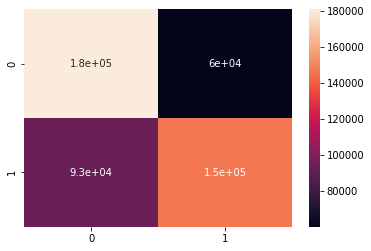

In [ ]:
pred_svm = svm_classifier.predict(submission_feature_set)
acc = accuracy_score(y_test, pred_svm)
matrix = consusion_matrix(y_test, pred_svm)
precision_recall_f1_score(matrix)

sns.heatmap(matrix, annot=True)
print("accuracy on submission svm Model : ", acc)

## downloaded
# df = pd.DataFrame({'svm': pred_svm})
# df.to_csv('predictions_svm.csv')

For Negative class  recall 0.5546738135157396  precision  0.6901623140151909
F1 Score for Neg class 0.6150447503784252
For Positive class  recall 0.752629174281442  precision  0.6298047012126667
F1 Score for Pos Class 0.6857606727306788
Macro Averge F1 Score 0.650402711554552
accuracy on submission Decision Tree Model :  0.6539787845386752


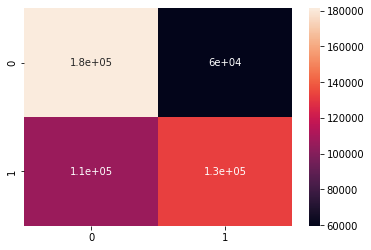

In [ ]:
pred_dtree = decision_tree_model.predict(submission_feature_set)
acc = accuracy_score(y_test, pred_dtree)
matrix = consusion_matrix(y_test, pred_dtree)
precision_recall_f1_score(matrix)

sns.heatmap(matrix, annot=True)

print("accuracy on submission Decision Tree Model : ", acc)

## downloaded
# df = pd.DataFrame({'dtree': pred_dtree})
# df.to_csv('predictions_dtree.csv')
# 0.6553414747475168

For Negative class  recall 0.5537916069121515  precision  0.7307615915962307
F1 Score for Neg class 0.6300862222750788
For Positive class  recall 0.7973085230104668  precision  0.6426923707902411
F1 Score for Pos Class 0.7116997039527956
Macro Averge F1 Score 0.6708929631139372
accuracy on submission MLP Model :  0.6759526850622899


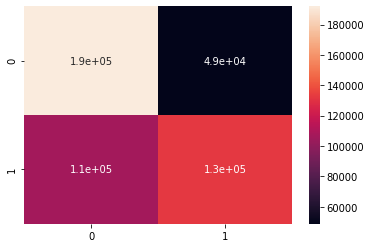

In [ ]:
pred_mlp = mlp_classifier.predict(submission_feature_set)
acc = accuracy_score(y_test, pred_mlp)
matrix = consusion_matrix(y_test, pred_mlp)
precision_recall_f1_score(matrix)

sns.heatmap(matrix, annot=True)

print("accuracy on submission MLP Model : ", acc)

## downloaded
# df = pd.DataFrame({'mlp': pred_mlp})
# df.to_csv('predictions_mlp.csv')
# 0.6818243379805098